In [1]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


In [2]:
#f = r.TFile("./data/gm2lostMuonTree_full_run2timingoffsets.root")
#f = r.TFile("./data/gm2offline_full_allSubruns.root") # energy ending at 1000
f = r.TFile("./data/gm2offline_full_allRuns_EnergyFix.root")
f.cd("lostMuonTree")
f.ls()

t = f.Get("lostMuonTree/lostMuonCoincidences")
#t.Print()

TFile**		./data/gm2offline_full_allRuns_EnergyFix.root	
 TFile*		./data/gm2offline_full_allRuns_EnergyFix.root	
  TDirectoryFile*		lostMuonTree	lostMuonTree (LostMuonTree) folder
   KEY: TTree	lostMuonCoincidences;57	lostMuonCoincidences
   KEY: TTree	lostMuonCoincidences;56	lostMuonCoincidences
  KEY: TDirectoryFile	lostMuonTree;1	lostMuonTree (LostMuonTree) folder


In [3]:
cutString = "coinNum == 1 && nHit == 1"

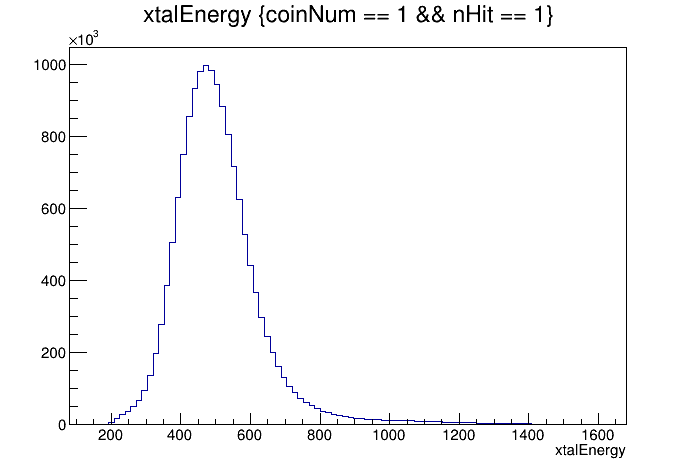

In [4]:
c = r.TCanvas()
t.Draw("xtalEnergy", cutString)
c.Draw()

Info in <TCanvas::SaveAs>: ROOT file ./deltaTCalos.root has been created


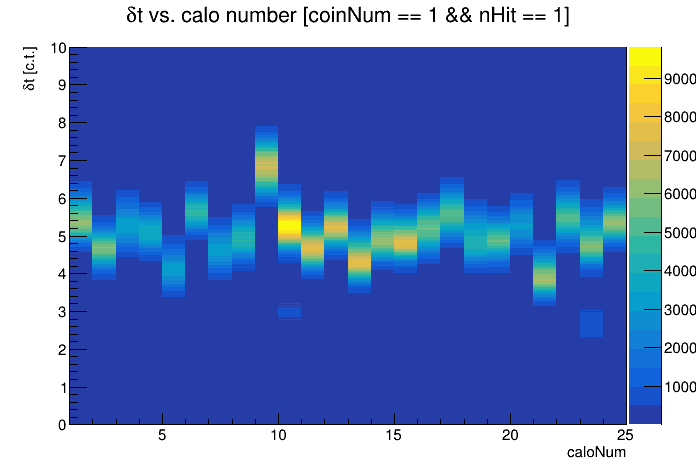

In [5]:
c = r.TCanvas()
deltaTCalos = r.TH2D("deltaTCalos","#deltat vs. calo number ["+str(cutString)+"]; caloNum; #deltat [c.t.]", 24,1,25,1000,0,10)
t.Draw("deltaT:caloNum>>deltaTCalos",cutString,"goff")
deltaTCalos.Draw("colz")
c.Draw()
c.Print("./deltaTCalos.root")

Info in <TCanvas::SaveAs>: ROOT file ./deltaTCalos.root has been created


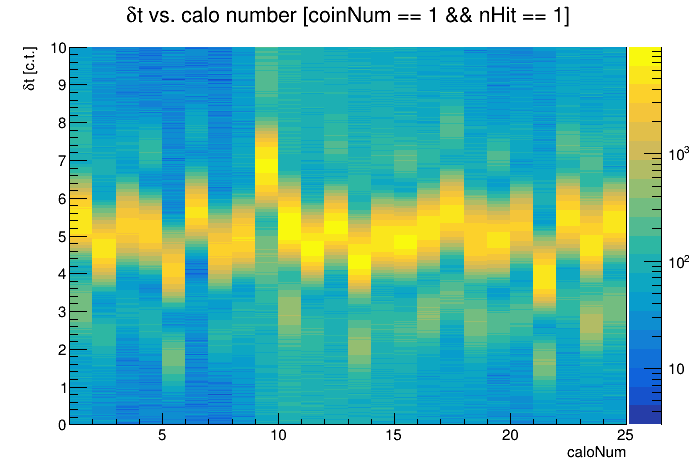

In [6]:
c = r.TCanvas()
deltaTCalos.Draw("colz")
c.Draw()
c.SetLogz()

c.Print("./deltaTCalos.root")

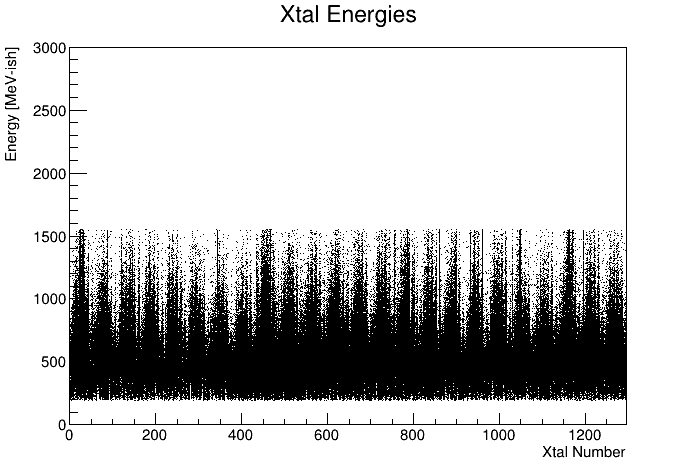

In [8]:
c = r.TCanvas()
allEnergies = r.TH2D("energyXtal","Xtal Energies; Xtal Number; Energy [MeV-ish]", 1296,-0.5,1295.5,400,0.0,3000.0)
t.Draw("xtalEnergy:(caloNum-1)*54 + xtalNum>>energyXtal",cutString,"goff")
allEnergies.Draw()
c.Draw()

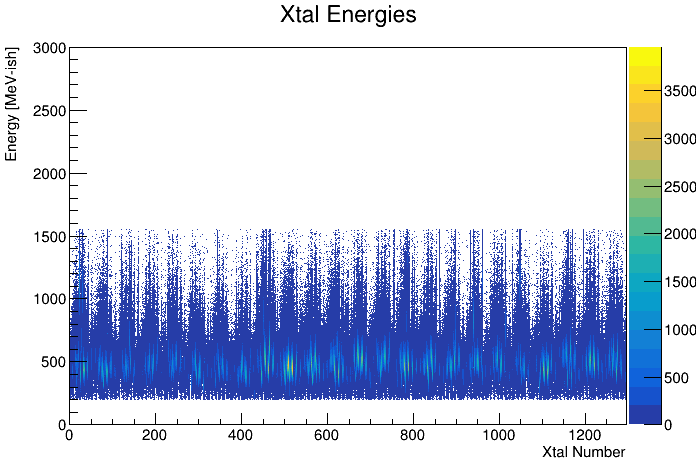

In [9]:
allEnergies.Draw("colz")
c.Draw()

In [10]:
targetE = 170.0 #MeV
scales = []
runningCalo = []

uncalibratedAllXtals = r.TH1D("uncalibratedAllXtals","All crystals",100,0.0,1000.0)
calibratedXtals = r.TH1D("calibratedXtals","All crystals; Energy [MeV]; N / 5 MeV",100,0.0,1000.0)

#current bad xtals
ding = [ #(36, 100, 800)
       ]

#problemXtals = [3*54+6, 3*54 + 1, 5*54+47, 16*54 + 18, 16*54 + 27, 16*54 + 5, 16*54+4, 
#                16*54 + 45, 49, 45 + 54, 3*54 + 49, 8*54+18, 9*54+6, 11*54 + 2, 18*54 + 27, 
#                18*54 + 7, 21*54 + 4, 4*54 + 46, 47 + 54, 48+54, 5*54 + 47, 5*54 + 1]
#lower = [ 400, 375, 200, 450, 425, 350, 500, 350, 450, 150, 420, 350, 500, 450, 420, 420, 400, 200,350, 250, 200, 300]
#upper = [ 600, 575, 600, 450, 620, 600, 650, 550, 640, 850, 675, 600, 650, 750, 575, 600, 600, 400, 650, 550, 600, 600]

if(len(ding) > 0):
    problemXtals, lower, upper = zip(*ding)
else:
    problemXtals, lower, upper = ([],[],[])


if((len(problemXtals) != len(lower)) or (len(problemXtals) != len(upper)) or (len(upper) != len(lower))):
    print("WARNING! VECTORS HAVE DIFFERENT LENGTHS")


In [11]:
laserConstants = [0.3 for x in range(24*54)]

In [12]:
with open("./data/gains_iter20.txt") as file:
    for line in file:
        if("calo" in line):
            calo = int(line.split("calo")[1].split(" ")[0])
            #print(calo)
        if (("xtal" in line)):
            xtal = int(line.split("xtal")[1].split(" ")[0])
            constant = float(line.split("xtal")[1].split(" ")[2][:-1])
            laserConstants[(calo-1)*54 + xtal] = constant
            #print(xtal, contsant)

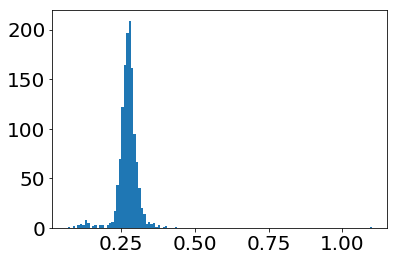

In [13]:
len(laserConstants)
plt.hist(laserConstants, bins=125)
plt.show()

In [14]:
print("Laser factor:", np.mean(laserConstants))
#laserFactor = 0.2749; #jasons value
laserFactor = np.mean(laserConstants); #calculated from the values brynn sent

Laser factor: 0.27381481481481484


In [15]:
projHist = allEnergies.ProjectionY("_py"+str(1),1,-1,"").Clone()
#projHist->Add(allEnergies.at(0)->ProjectionY(Form("_py%i",0),1,-1,""));
#projHist->Add(allEnergies.at(2)->ProjectionY(Form("_py%i",2),1,-1,""));
tempMean = projHist.GetMean()
tempSig = projHist.GetRMS()
binmax = projHist.GetMaximumBin()
peak = projHist.GetXaxis().GetBinCenter(binmax)
projHist.Fit("gaus","Q","",peak-75, peak+75)

avgPeak = peak;

scaleFactor = targetE / projHist.GetFunction("gaus").GetParameter(1)
print( "average calibration constant is : " , scaleFactor )

for k in range( 1,projHist.GetXaxis().GetNbins() ):
    uncalibratedAllXtals.Fill(projHist.GetXaxis().GetBinCenter(k) * scaleFactor,
                              projHist.GetBinContent(k))

average calibration constant is :  0.3573004564254248


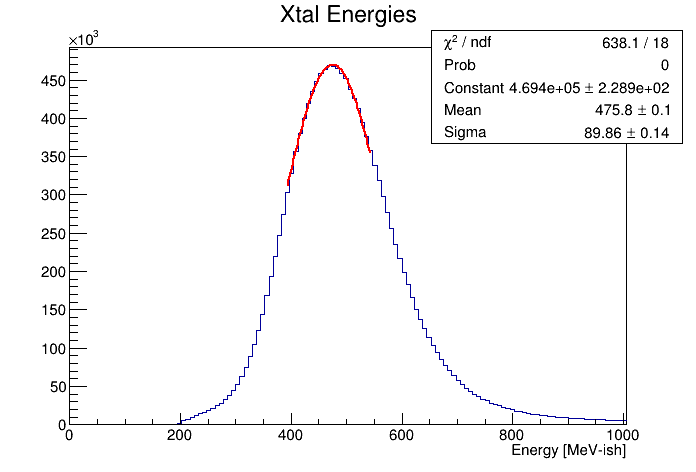

In [16]:
c = r.TCanvas()
projHist.Draw()
projHist.GetXaxis().SetRangeUser(0,1000)
c.Draw()

---

In [17]:
caloLow = 1
caloHigh = 24

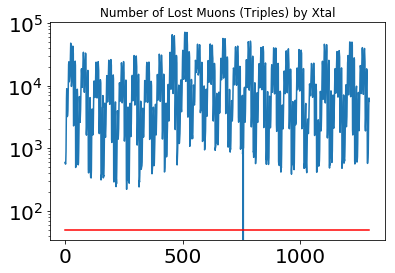

In [18]:
nMuons = []
xtalsBelowThreshold = []
for xIdx in range( (caloLow-1)*54+1 , caloHigh*54+1 ):
    #print("Starting crystal", xIdx)
    #projHist.Clear();
    #projHist=allEnergies.ProjectionY("_py"+str(xIdx*10+0),xIdx,xIdx,"").Clone()
    projHist = allEnergies.ProjectionY("_py",xIdx,xIdx,"").Clone("py")
    nMuons.append(projHist.GetEntries())
    if(projHist.GetEntries() <= 50):
        xtalsBelowThreshold.append(xIdx)
plt.plot(nMuons)
plt.yscale("log")
plt.plot([0,1296], [50,50], "r")
plt.title("Number of Lost Muons (Triples) by Xtal")
plt.show()

In [19]:
#print(xtalsBelowThreshold)
print("Crystals below threshold of 50 mips:")
for x in xtalsBelowThreshold:
    print("   - calo", int(np.ceil(x/54)), "xtal", x%54)

Crystals below threshold of 50 mips:
   - calo 15 xtal 3


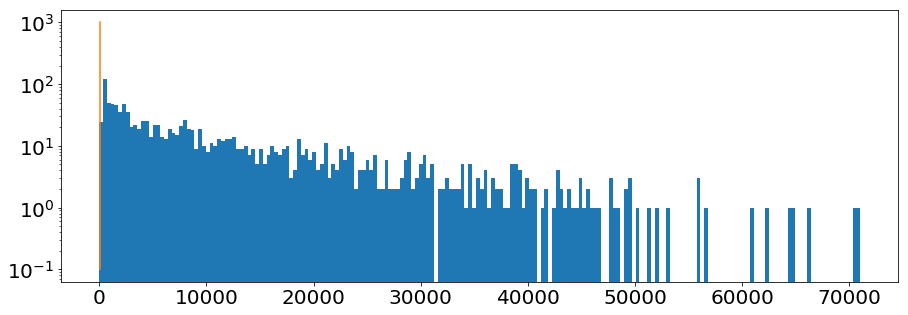

In [20]:
fig,ax = plt.subplots(figsize=(15,5))
plt.hist(nMuons,bins=200)#, range=(0,100))
plt.plot([50,50],[0.1,1000])
plt.yscale("log")
plt.show()

In [21]:
c2 = r.TCanvas("c2","c2",1800,1200);

#for(int xIdx = (caloLow-1)*54 + 1; xIdx <= caloHigh*54; xIdx++){//allEnergies.at(0)->GetXaxis()->GetNbins()
#for xIdx in range( (caloLow-1)*54 + 1, caloHigh*54 ):

energyMinFit = 50.
energyMaxFit = 3000.

allFitHists = [ np.nan for x in range(54*24) ]

scales = []

for xIdx in range( (caloLow-1)*54+1 , caloHigh*54+1 ): #this is the bin index, not the crystal number
    print("Starting crystal", xIdx - 1)
    #projHist.Clear();
    #projHist=allEnergies.ProjectionY("_py"+str(xIdx*10+0),xIdx,xIdx,"").Clone()
    projHist = allEnergies.ProjectionY("_py",xIdx,xIdx,"").Clone("py")
    projHist.SetTitle("Xtal "+str(xIdx - 1)+" (calo "+str(int(np.ceil(xIdx / 54)))+", xtal "+str((xIdx - 1) % 54)+")")
    #for(int hit = 1; hit < allEnergies.size(); hit++){
    #    projHist->Add(allEnergies.at(hit)->ProjectionY(Form("_py%i",xIdx*10+hit),xIdx,xIdx,""));
    #}


    #projHist = allEnergies->ProjectionY(Form("_py%i",xIdx),xIdx,xIdx,"");
    #projHist->Rebin(4);

    if(projHist.GetEntries() > 50):
        
        tempMean = projHist.GetMean();
        tempSig = projHist.GetRMS();
        binmax = projHist.GetMaximumBin();
        peak = projHist.GetXaxis().GetBinCenter(binmax);
        peakValue = projHist.GetBinContent(binmax);
        
        while(peakValue < 50):
            #print("hi")
            projHist.Rebin(2);
            binmax = projHist.GetMaximumBin();
            peak = projHist.GetXaxis().GetBinCenter(binmax);
            peakValue = projHist.GetBinContent(binmax);
        #print("continuing")
                                                                
        mini = min([energyMinFit,peak - 60]);
        maxi = max([energyMaxFit,peak + 60]);

        #if(std::find(problemXtals.begin(),problemXtals.end(),xIdx-1)!=problemXtals.end()):
        problemXtal = False
        if( xIdx-1 in problemXtals ):
            problemXtal = True
            #pos = std::find(problemXtals.begin(),problemXtals.end(),xIdx-1) - problemXtals.begin();
            pos = problemXtals.index( xIdx - 1 )
            mini = lower[pos];
            maxi = upper[pos];
            print("     Problem xtal", xIdx - 1)

        #print("fitting")
        
        #define new function in order to set limits
        func = r.TF1("gaus","gaus")
        func.SetParameters(1,500,1)
        func.SetParLimits(0,0,10000000)
        func.SetParLimits(1,100,3000)
        
        for thisMacroSucks in range(2):
            #projHist.Fit("gaus","RQ","",mini, maxi);
            projHist.Fit(func,"RQ","",mini, maxi);
        #if(not problemXtal):
        print("     ",mini, maxi)
        mini = max([energyMinFit,projHist.GetFunction("gaus").GetParameter(1) - 1.5*projHist.GetFunction("gaus").GetParameter(2)]);
        maxi = min([energyMaxFit,projHist.GetFunction("gaus").GetParameter(1) + 1.4*projHist.GetFunction("gaus").GetParameter(2)]);
        #delete projHist->GetFunction("gaus");
        print("     ",mini, maxi)
        #projHist.Fit("gaus","RQ","",mini, maxi);
        projHist.Fit(func,"RQ","",mini, maxi);
        #print("endfitting")
        runningCalo.append(projHist);
        scaleFactor = targetE / projHist.GetFunction("gaus").GetParameter(1);
        scales.append(scaleFactor);

        allFitHists[xIdx - 1] = projHist.Clone("h_"+str(xIdx - 1))
        
        for k in range(1, projHist.GetXaxis().GetNbins() ):
            calibratedXtals.Fill(projHist.GetXaxis().GetBinCenter(k) * scaleFactor,
                                 projHist.GetBinContent(k));

    else:
        print( "Not enough events in channel : " , xIdx) 
        scales.append(1.0);
        runningCalo.append(projHist);

Starting crystal 0
      50.0 3000.0
      312.1855348789321 622.6522994654636
Starting crystal 1
      50.0 3000.0
      400.74438721439645 550.3578516964205
Starting crystal 2
      50.0 3000.0
      357.6866222929416 586.6606173261746
Starting crystal 3
      50.0 3000.0
      393.5846953016691 504.1483829819181
Starting crystal 4
      50.0 3000.0
      331.41883131646534 615.8485787969755
Starting crystal 5
      50.0 3000.0
      405.18850842890606 594.1177381876828
Starting crystal 6
      50.0 3000.0
      336.4993559256435 570.3285619770672
Starting crystal 7
      50.0 3000.0
      365.8042672891614 477.59898795508906
Starting crystal 8
      50.0 3000.0
      288.1169564495201 536.197442588022
Starting crystal 9
      50.0 3000.0
      398.9227073066139 606.8713920602089
Starting crystal 10
      50.0 3000.0
      358.118290724171 536.5883219102647
Starting crystal 11
      50.0 3000.0
      427.64868918908553 625.5689631765241
Starting crystal 12
      50.0 3000.0
      478

In [22]:
print(allFitHists[:5],"...", allFitHists[-5:])

[<ROOT.TH1D object ("h_0") at 0x7fffc8e0d970>, <ROOT.TH1D object ("h_1") at 0x7fffc8fdb560>, <ROOT.TH1D object ("h_2") at 0x7fffc92f6340>, <ROOT.TH1D object ("h_3") at 0x7fffc8d884b0>, <ROOT.TH1D object ("h_4") at 0x7fffc85554b0>] ... [<ROOT.TH1D object ("h_1291") at 0x7f4b4aed7c40>, <ROOT.TH1D object ("h_1292") at 0x7f4b4aedb9e0>, <ROOT.TH1D object ("h_1293") at 0x7f4b4aee2780>, <ROOT.TH1D object ("h_1294") at 0x7f4b4aee9c20>, <ROOT.TH1D object ("h_1295") at 0x7f4b4aef5470>]


Error: no histogram in entry 758


Info in <TCanvas::Print>: png file ./images/AllFits_Calo01.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/AllFits_Calo01.root has been created
Info in <TCanvas::Print>: png file ./images/AllFits_Calo02.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/AllFits_Calo02.root has been created
Info in <TCanvas::Print>: png file ./images/AllFits_Calo03.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/AllFits_Calo03.root has been created
Info in <TCanvas::Print>: png file ./images/AllFits_Calo04.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/AllFits_Calo04.root has been created
Info in <TCanvas::Print>: png file ./images/AllFits_Calo05.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/AllFits_Calo05.root has been created
Info in <TCanvas::Print>: png file ./images/AllFits_Calo06.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/AllFits_Calo06.root has been created
Info in <TCanvas::Prin

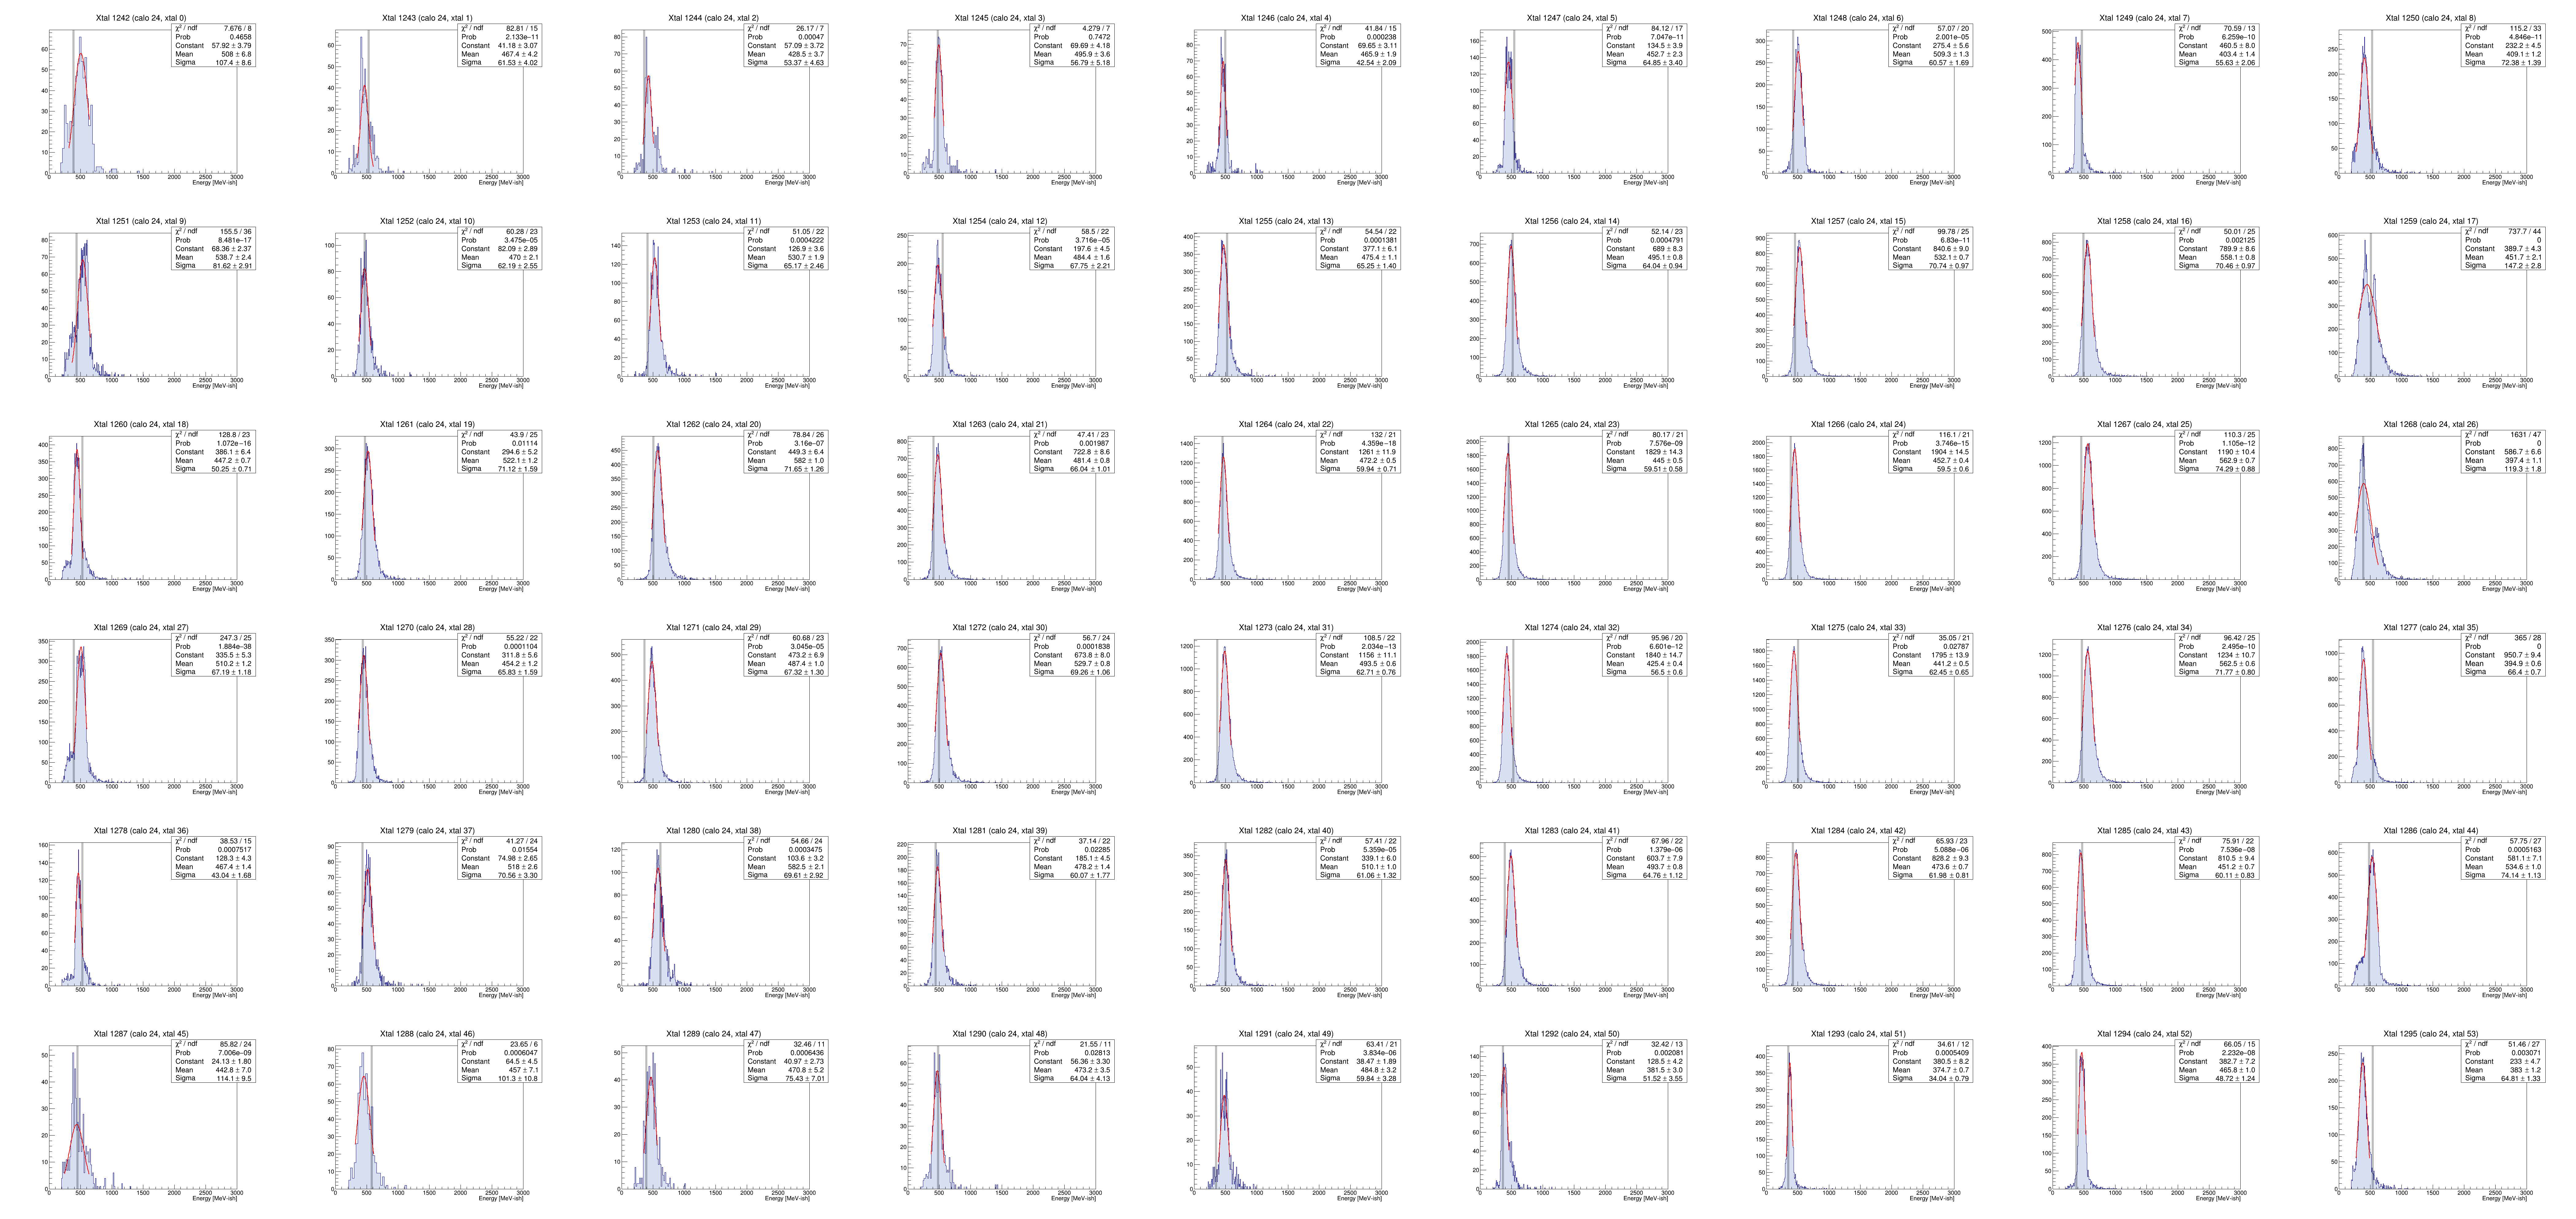

In [23]:
c = r.TCanvas("c","c", 8400, 4000)
c.Divide(9,6)
lines = [-1 for i in range(len(allFitHists))]
for i, h in enumerate(allFitHists):
    #print("Starting calo", i+1)
    #if(i > 3):
    #    break
    #print((i%54) + 1)
    
    c.cd((i%54) + 1 )
    try:
        h.SetFillColorAlpha(38,0.3)
        h.Draw()
        peakValue = h.GetBinContent(h.GetMaximumBin())
        xValue = avgPeak * laserFactor / laserConstants[i]
        line1 = r.TLine( xValue, 0, xValue , 1.05*peakValue);
        line1.SetLineColorAlpha(1,0.25);
        line1.SetLineWidth(7)
        lines[i] = line1.Clone("line_"+str(i))
        lines[i].Draw()
        
    except:
        print("Error: no histogram in entry", i)
        #continue
        

    if( i % 54 == 53):
        c.Draw()
        if(True):
            c.Print("./images/AllFits_Calo"+str(int(np.ceil(i/54))).zfill(2)+".png")
            #c.Print("./images/AllFits_Calo"+str(int(np.ceil(i/54))).zfill(2)+".pdf")
            c.Print("./images/AllFits_Calo"+str(int(np.ceil(i/54))).zfill(2)+".root")

c.Draw()

In [24]:
fitPars = [ np.nan for i in range(24*54) ]
for i, h in enumerate(allFitHists):
    try:
        fitPars[i] = (
            h.GetFunction("gaus").GetParameter(0),
            h.GetFunction("gaus").GetParError(0) ,
            h.GetFunction("gaus").GetParameter(1),
            h.GetFunction("gaus").GetParError(1),
            h.GetFunction("gaus").GetParameter(2),
            h.GetFunction("gaus").GetParError(2),
            h.GetFunction("gaus").GetChisquare(),
            h.GetFunction("gaus").GetNDF() 
        )
    except:
        fitPars[i] = [np.nan for x in range(8)]
        print("Error: no histogram in", i)

Error: no histogram in 758


Bad fit in xtal 17
Bad fit in xtal 26
Bad fit in xtal 27
Bad fit in xtal 44
Bad fit in xtal 71
Bad fit in xtal 72
Bad fit in xtal 80
Bad fit in xtal 89
Bad fit in xtal 159
Bad fit in xtal 197
Bad fit in xtal 216
Bad fit in xtal 261
Bad fit in xtal 305
Bad fit in xtal 359
Bad fit in xtal 405
Bad fit in xtal 422
Bad fit in xtal 437
Bad fit in xtal 449
Bad fit in xtal 450
Bad fit in xtal 458
Bad fit in xtal 467
Bad fit in xtal 476
Bad fit in xtal 492
Bad fit in xtal 503
Bad fit in xtal 504
Bad fit in xtal 512
Bad fit in xtal 521
Bad fit in xtal 522
Bad fit in xtal 538
Bad fit in xtal 558
Bad fit in xtal 566
Bad fit in xtal 596
Bad fit in xtal 611
Bad fit in xtal 612
Bad fit in xtal 620
Bad fit in xtal 629
Bad fit in xtal 647
Bad fit in xtal 655
Bad fit in xtal 665
Bad fit in xtal 674
Bad fit in xtal 675
Bad fit in xtal 683
Bad fit in xtal 719
Bad fit in xtal 728
Bad fit in xtal 737
Bad fit in xtal 773
Bad fit in xtal 782
Bad fit in xtal 791
Bad fit in xtal 827
Bad fit in xtal 845
Bad fit 

Info in <TCanvas::Print>: png file ./images/BadFit_0017.png has been created
Info in <TCanvas::Print>: png file ./images/BadFit_0026.png has been created
Info in <TCanvas::Print>: png file ./images/BadFit_0027.png has been created
Info in <TCanvas::Print>: png file ./images/BadFit_0044.png has been created
Info in <TCanvas::Print>: png file ./images/BadFit_0071.png has been created
Info in <TCanvas::Print>: png file ./images/BadFit_0072.png has been created
Info in <TCanvas::Print>: png file ./images/BadFit_0080.png has been created
Info in <TCanvas::Print>: png file ./images/BadFit_0089.png has been created
Info in <TCanvas::Print>: png file ./images/BadFit_0159.png has been created
Info in <TCanvas::Print>: png file ./images/BadFit_0197.png has been created
Info in <TCanvas::Print>: png file ./images/BadFit_0216.png has been created
Info in <TCanvas::Print>: png file ./images/BadFit_0261.png has been created
Info in <TCanvas::Print>: png file ./images/BadFit_0305.png has been created

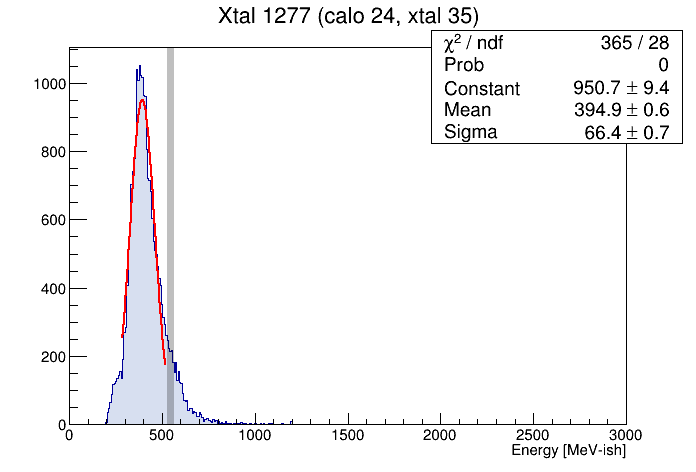

In [25]:
badFits = []
os.system("rm -f ./images/BadFit*")
c = r.TCanvas()
chiSqCut = 10
for i, x in enumerate(fitPars):
    if(x[7] != 0):
        if(x[6]/x[7] > chiSqCut or x[2] < 101):
            allFitHists[i].Draw("")
            lines[i].Draw("SAME")
            c.Draw()
            c.Print("./images/BadFit_"+str(i).zfill(4)+".png")
            print("Bad fit in xtal", i)
            badFits.append(i)

In [26]:
const, constErrs, means, meanErrs, sigs, sigErrs, chiSq, ndf = zip(*fitPars)
xtalNums = [i for i in range(len(const))]

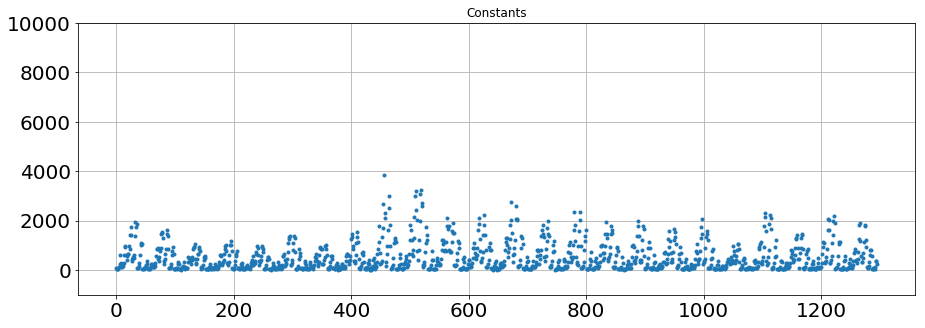

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title("Constants")
plt.errorbar(xtalNums, const, yerr=constErrs, fmt=".")
plt.ylim(-1000,10000)
plt.grid()
plt.show()

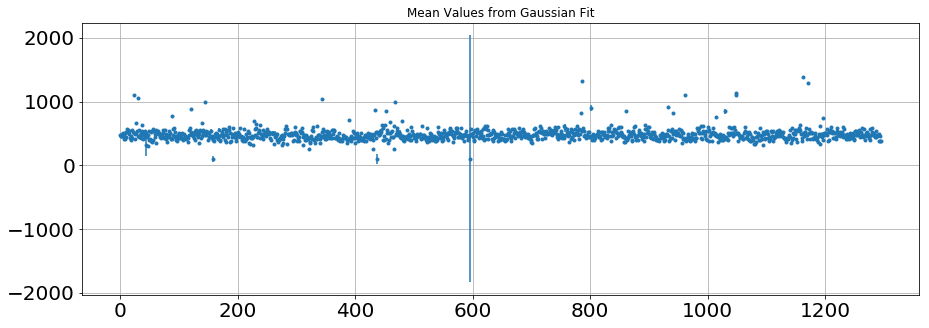

Crystals with high mean values ( > 750 MeV): [24, 31, 88, 121, 145, 344, 434, 452, 468, 785, 786, 802, 861, 932, 941, 961, 1015, 1030, 1048, 1049, 1162, 1171]


In [28]:
fig, ax = plt.subplots(figsize=(15,5))
plt.errorbar(xtalNums, means, yerr=meanErrs, fmt=".")
plt.grid()
plt.title("Mean Values from Gaussian Fit")
plt.show()

highMeans = []
for i, x in enumerate(means):
    if(x > 750):
        highMeans.append(i)
print("Crystals with high mean values ( > 750 MeV):", highMeans)

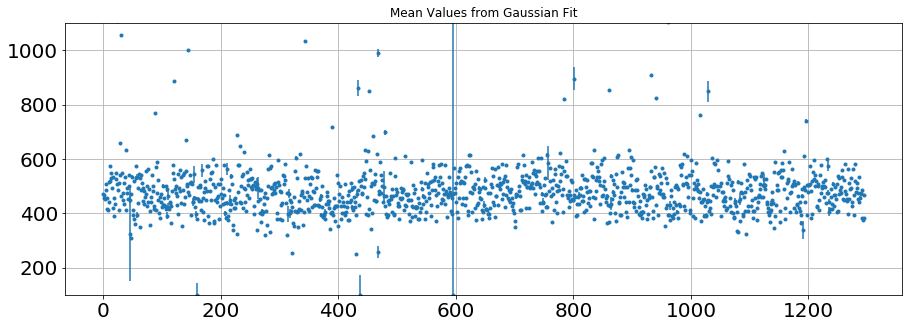

Crystals with high mean values ( > 750 MeV): [24, 31, 88, 121, 145, 344, 434, 452, 468, 785, 786, 802, 861, 932, 941, 961, 1015, 1030, 1048, 1049, 1162, 1171]


In [29]:
fig, ax = plt.subplots(figsize=(15,5))
plt.errorbar(xtalNums, means, yerr=meanErrs, fmt=".")
plt.grid()
plt.title("Mean Values from Gaussian Fit")
plt.ylim(100,1100)
plt.show()

highMeans = []
for i, x in enumerate(means):
    if(x > 750):
        highMeans.append(i)
print("Crystals with high mean values ( > 750 MeV):", highMeans)

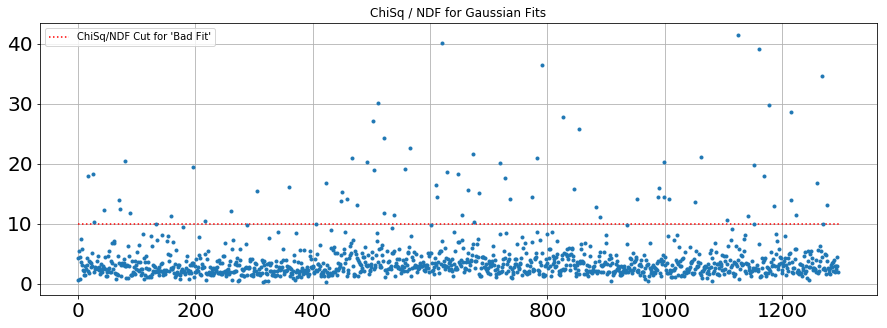

In [30]:
fig, ax = plt.subplots(figsize=(15,5))
plt.errorbar(xtalNums, [x/(y+0.001) for (x,y) in zip(chiSq, ndf)], yerr=0, fmt=".")
plt.plot([0, 1296],[chiSqCut, chiSqCut], "r:", label="ChiSq/NDF Cut for 'Bad Fit'")
plt.title("ChiSq / NDF for Gaussian Fits")
plt.grid()
plt.legend()
plt.show()

---

### Many of the bad fids appear to be because of multiple peaks, lets use a peak finding algorithm like TSpectrum to try to identify them

We could also just use a double/triple gaussian fit, which will be plan B if this option fails / doesn't produce convincing results

In [31]:
spec = r.TSpectrum(6)

ERROR: No peaks found in xtal 261


Info in <TCanvas::Print>: png file ./images/TSpectrum_0017.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/TSpectrum_0017.root has been created
Info in <TCanvas::Print>: png file ./images/TSpectrum_0026.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/TSpectrum_0026.root has been created
Info in <TCanvas::Print>: png file ./images/TSpectrum_0027.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/TSpectrum_0027.root has been created
Info in <TCanvas::Print>: png file ./images/TSpectrum_0044.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/TSpectrum_0044.root has been created
Info in <TCanvas::Print>: png file ./images/TSpectrum_0071.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/TSpectrum_0071.root has been created
Info in <TCanvas::Print>: png file ./images/TSpectrum_0072.png has been created
Info in <TCanvas::SaveAs>: ROOT file ./images/TSpectrum_0072.root has been created
Info in <TCanvas::Prin

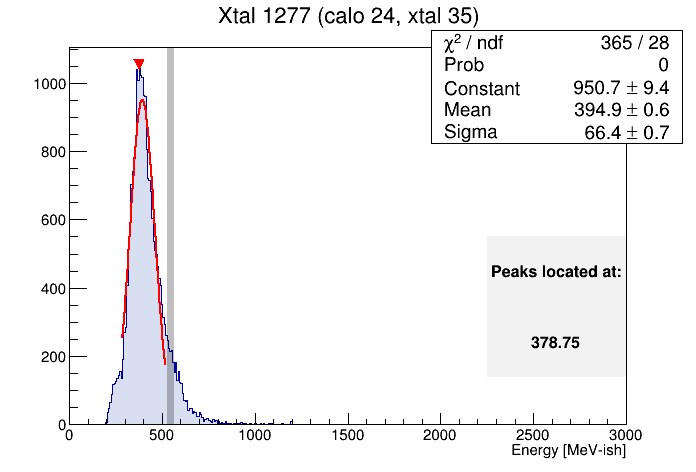

In [32]:
#i = 1007
#i = 1061
#i = 1124

badFitPeaks = []

os.system("rm -f ./images/TSpec*")
for i in badFits:
    c = r.TCanvas()
    allFitHists[i].Draw()
    npeaks = spec.Search(allFitHists[i], 
                2,      #sigma, see manual
                "",     #options
                0.05)   #threshold as a fraction of highest peak, only look for peaks which are comperable in size.
    #print("Found", npeaks, "peaks")
    #print("Peaks:", [spec.GetPositionX()[x] for x in range(npeaks)])
    spec.Draw("SAME")
    lines[i].Draw("SAME")
    c.Draw()
    #text = r.TPaveText(2000,100,3000,500,"")
    text = r.TPaveText(.7,.2,.9,.5,"NDC")
    text.AddText("Peaks located at:")
    for x in range(npeaks):
        text.AddText(str(spec.GetPositionX()[x]))
    if(npeaks == 0):
        print("ERROR: No peaks found in xtal", i)
        text.AddText("No peaks found")
    text.Draw("SAME")
    
    badFitPeaks.append( (i, 
                         [spec.GetPositionX()[x] for x in range(npeaks)], 
                         [spec.GetPositionY()[x] for x in range(npeaks)]))
    
    c.Print("./images/TSpectrum_"+str(i).zfill(4)+".png")
    c.Print("./images/TSpectrum_"+str(i).zfill(4)+".root")

In [33]:
for i, x in enumerate(badFitPeaks):
    print(i, x)

0 (17, [393.75, 498.75, 326.25], [806.0, 654.0, 409.0])
1 (26, [401.25], [1563.0])
2 (27, [461.25, 528.75, 318.75], [429.0, 398.0, 64.0])
3 (44, [483.75], [1048.0])
4 (71, [446.25], [769.0])
5 (72, [423.75, 506.25, 296.25], [445.0, 403.0, 90.0])
6 (80, [341.25], [1235.0])
7 (89, [416.25], [1597.0])
8 (159, [408.75, 626.25], [157.0, 91.0])
9 (197, [363.75, 476.25], [905.0, 369.0])
10 (216, [390.0], [75.0])
11 (261, [], [])
12 (305, [393.75, 483.75, 311.25], [789.0, 673.0, 228.0])
13 (359, [416.25, 558.75, 266.25], [656.0, 204.0, 128.0])
14 (405, [371.25], [361.0])
15 (422, [536.25, 363.75], [426.0, 188.0])
16 (437, [483.75, 821.25, 701.25, 213.75], [177.0, 60.0, 73.0, 10.0])
17 (449, [506.25, 408.75, 318.75], [780.0, 666.0, 279.0])
18 (450, [386.25, 521.25], [357.0, 181.0])
19 (458, [393.75], [2138.0])
20 (467, [386.25, 513.75, 611.25], [1170.0, 719.0, 449.0])
21 (476, [446.25, 251.25], [1076.0, 135.0])
22 (492, [536.25, 393.75], [446.0, 209.0])
23 (503, [348.75, 521.25], [1244.0, 326.0

In [34]:
#fit function
'''
Double_t fpeaks(Double_t *x, Double_t *par) {
   Double_t result = par[0] + par[1]*x[0];
   for (Int_t p=0;p<npeaks;p++) {
      Double_t norm  = par[3*p+2];
      Double_t mean  = par[3*p+3];
      Double_t sigma = par[3*p+4];
      result += norm*TMath::Gaus(x[0],mean,sigma);
   }
   return result;
}
'''

def fpeaks(x,p):
    result = p[0] + p[1]*x[0]
    #print(len(p), (len(p) -2) / 3 )
    for i in range(int((len(p) -2) /3)):
        norm = p[3*i+2]
        mean = p[3*i+3]
        sigma = p[3*i+4]
        result += norm*r.TMath.Gaus(x[0], mean, sigma)
    return result

In [35]:
fpeaks([30],[1,2,3,4,5,6,7,10])

61.426036153874655

---

### Now lets use these peaks to decide the energy calibration for these crystals.

Initial plan is to take the largest amplitude peak if no other peak is a certain amount (maybe 75%?). If there are two peaks of comperable amplitude, then take the higher energy of the two (and flag for manual review).

In [36]:
peakCutoffFactor = 0.75

xtalsForReview = []
newLines = [-1 for x in range(54*24)]

os.system("rm -f ./images/Review*")

for j, (i, peakX, peakY) in enumerate(badFitPeaks):
    print("Starting xtal", i )
    if(len(peakY) > 0):
        maxPeak = max(peakY)
        maxPeakIndex = peakY.index(maxPeak)
        otherPeaks = []
        for k, pk in enumerate(peakY):
            if(pk < maxPeak and pk > peakCutoffFactor*maxPeak):
                otherPeaks.append(k)
        if(len(otherPeaks) > 0):
            #for peaks in [maxPeakIndex]+[otherPeaks]:
            #    if(peakX[peak] > max(peakX)):
            #        finalPeak = 
            finalPeak = peakX[ peakX.index(max(peakX)) ]
            print("     *** FLAG FOR REVIEW ***")
            xtalsForReview.append(i)
        else:
            finalPeak = peakX[maxPeakIndex]
        print("     Final peak for xtal", i, "=", finalPeak)
        print("    ", 
              finalPeak, 
              otherPeaks, 
              peakX,
              peakY )
        
        line1 = r.TLine( finalPeak, 0, finalPeak , 1.05*maxPeak);
        line1.SetLineColorAlpha(1,0.25);
        line1.SetLineWidth(7)
        newLines[i] = line1.Clone("line_"+str(i))
        c = r.TCanvas()
        allFitHists[i].Draw()
        newLines[i].Draw("SAME")
        c.Print("./images/ReviewHist_"+str(i).zfill(4)+".png")
        
        scaleFactor = targetE / finalPeak
        scales[i] = scaleFactor
        
    else:
        print("     No peaks found")

Starting xtal 17
     *** FLAG FOR REVIEW ***
     Final peak for xtal 17 = 498.75
     498.75 [1] [393.75, 498.75, 326.25] [806.0, 654.0, 409.0]
Starting xtal 26
     Final peak for xtal 26 = 401.25
     401.25 [] [401.25] [1563.0]
Starting xtal 27
     *** FLAG FOR REVIEW ***
     Final peak for xtal 27 = 528.75
     528.75 [1] [461.25, 528.75, 318.75] [429.0, 398.0, 64.0]
Starting xtal 44
     Final peak for xtal 44 = 483.75
     483.75 [] [483.75] [1048.0]
Starting xtal 71
     Final peak for xtal 71 = 446.25
     446.25 [] [446.25] [769.0]
Starting xtal 72
     *** FLAG FOR REVIEW ***
     Final peak for xtal 72 = 506.25
     506.25 [1] [423.75, 506.25, 296.25] [445.0, 403.0, 90.0]
Starting xtal 80
     Final peak for xtal 80 = 341.25
     341.25 [] [341.25] [1235.0]
Starting xtal 89
     Final peak for xtal 89 = 416.25
     416.25 [] [416.25] [1597.0]
Starting xtal 159
     Final peak for xtal 159 = 408.75
     408.75 [] [408.75, 626.25] [157.0, 91.0]
Starting xtal 197
     Final

Info in <TCanvas::Print>: png file ./images/ReviewHist_0017.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0026.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0027.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0044.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0071.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0072.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0080.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0089.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0159.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0197.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0216.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0305.png has been created
Info in <TCanvas::Print>: pn

In [37]:
print("Review these xtals:", xtalsForReview)

Review these xtals: [17, 27, 72, 305, 449, 512, 611, 629, 675, 719, 737, 791, 827, 854, 953, 1052, 1061, 1215, 1259]


---

### Some crystals may fail even after this step. These we can set manually

In [38]:
lostCauses = []

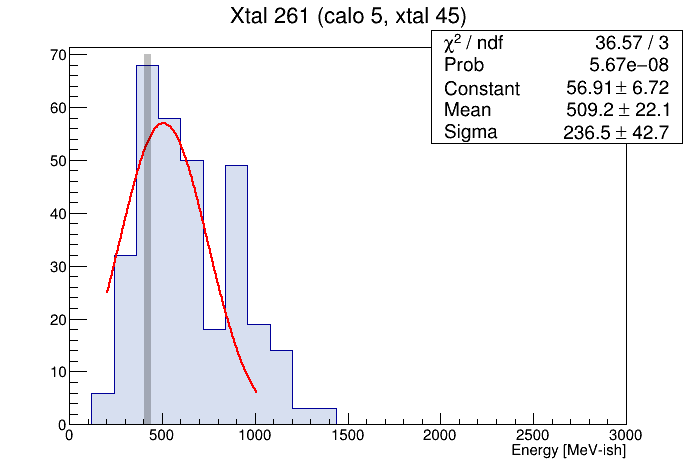

In [39]:
i = 261
c = r.TCanvas()
allFitHists[i].Draw()

finalPeak = allFitHists[i].GetBinCenter( allFitHists[i].GetMaximumBin() )

lostCauses.append((i, 
                   finalPeak))
line1 = r.TLine( finalPeak, 0, finalPeak , 70);
line1.SetLineColorAlpha(1,0.25);
line1.SetLineWidth(7)
line1.Draw("SAME")

c.Draw()

In [40]:
print(lostCauses)
for i, const in lostCauses:
    scaleFactor = targetE / const
    scales[i] = scaleFactor

[(261, 420.0)]


---

---


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


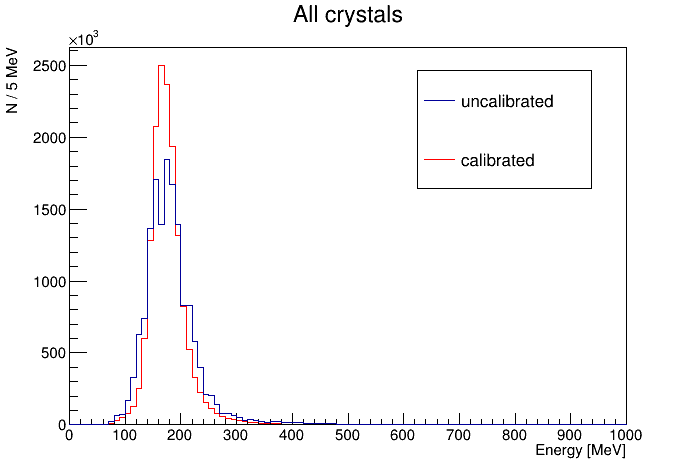

In [41]:
calibratedXtals.SetLineColor(2);
c1 = r.TCanvas("c1","c1",700,500);
leg1 = r.TLegend(0.6,0.6,0.85,0.85);
leg1.AddEntry(uncalibratedAllXtals,"uncalibrated","l");
leg1.AddEntry(calibratedXtals,"calibrated","l");
calibratedXtals.Draw("hist");
uncalibratedAllXtals.Draw("hist same");
leg1.Draw();
c1.Draw()
#c1.Print("./calibrationComparison.png");

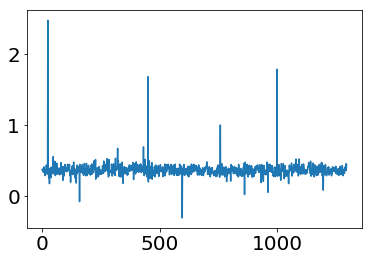

In [42]:
brynnScales = pandas.read_csv("./brynnConstants.txt", header=None)
brynnScales.head()
plt.plot(brynnScales[0])
plt.show()

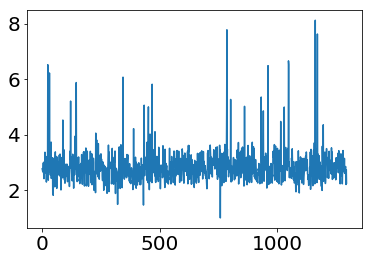

In [43]:
plt.plot([1/x for x in scales])
plt.show()

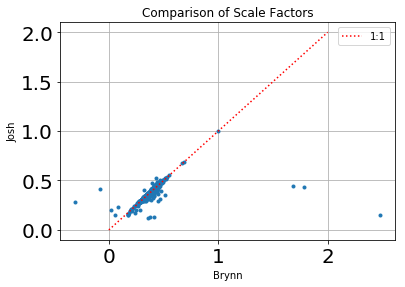

In [58]:
noint()
plt.plot(brynnScales[0], scales,".")
plt.title("Comparison of Scale Factors")
plt.xlabel("Brynn")
plt.ylabel("Josh")
#plt.ylim(0,2)
#plt.xlim(0,2)
plt.plot([0,2],[0,2],"r:",label="1:1")
plt.legend()
plt.grid()
plt.show()

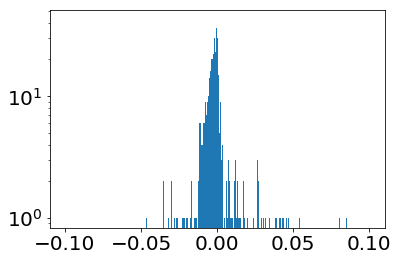

In [45]:
plt.hist([x-y for (x,y) in zip(brynnScales[0], scales)],bins=1000,range=(-0.1,0.1))
plt.yscale("log")
plt.show()

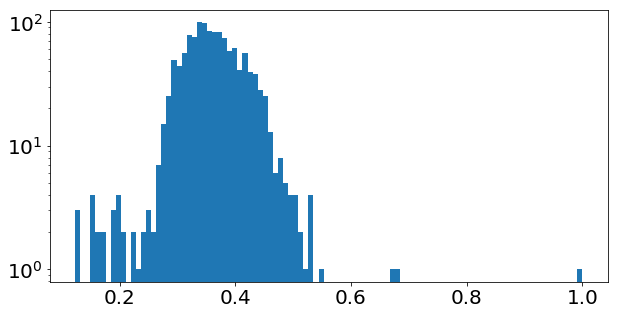

In [56]:
fig,ax = plt.subplots(figsize=(10,5))
#plt.hist([x for (x,y) in zip(brynnScales[0], scales)],bins=100,range=(0,2), alpha=0.3)
plt.hist([y for (x,y) in zip(brynnScales[0], scales)],bins=100)#,range=(0,2), alpha=0.3)
plt.yscale("log")
plt.show()

In [52]:
for i, x in enumerate(scales):
    if(x > 100):
        print(i, np.ceil(i/54), i %54, x)


****************************************
Minimizer is Linear
Chi2                      =      260.251
NDf                       =         1294
p0                        =      1.24819   +/-   0.0595282   
p1                        =     0.424845   +/-   0.0155336   


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3


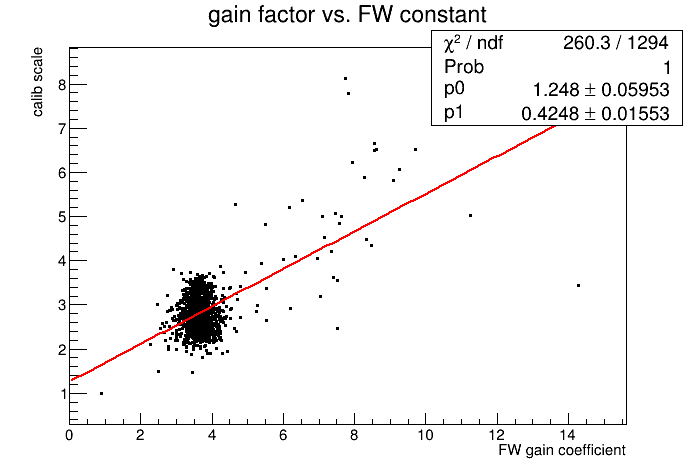

In [53]:
calibGain = r.TGraph();
for k in range(0, len(laserConstants)):
    #if(k%100 == 0):
    #    print("point", k)
    #//std::cout<< "laser "<<laserConstants.at(k) << std::endl;
    #//std::cout<< "calib "<<scales.at(k) << std::endl;
    calibGain.SetPoint(k, 1.0 / laserConstants[k], 1.0 / scales[k]);

c3 = r.TCanvas("c3","c3",700,500);
calibGain.SetTitle("gain factor vs. FW constant; FW gain coefficient; calib scale");
calibGain.SetMarkerStyle(7);
calibGain.Draw("apz");
calibGain.Fit("pol1")
c3.Draw();


In [54]:
for xtal, value in enumerate(scales):
    if(value == 1.0):
        print("Problem xtal:", xtal, "( calo", int(np.ceil(xtal/54)), "xtal", xtal%54,")")

Problem xtal: 758 ( calo 15 xtal 2 )


In [55]:
print("BEGIN_PROLOG")
print("absolute_calibration_constants : {")
#for(int calo = 1; calo <= 24; calo++){
for calo in range(1,25):
    #std::cout<<Form("\tcalo%i : {",calo)<<std::endl;
    print("\t"+"calo"+str(calo))
    #for(int xtal = 0; xtal < 54; xtal++){
    for xtal in range(54):
        #std::cout<<Form("\t\txtal%i : %0.3f",xtal,scales.at(54*(calo-1)+xtal))<<std::endl;
        print("\t"+"\t"+"xtal"+str(xtal)+" : "+str(scales[54*(calo-1)+xtal]))
    print("\t"+"}")
    #std::cout<<"\t}"<<std::endl;
print("}")
print("END_PROLOG")

BEGIN_PROLOG
absolute_calibration_constants : {
	calo1
		xtal0 : 0.361322789609175
		xtal1 : 0.3650877037103767
		xtal2 : 0.3725558401687027
		xtal3 : 0.3763907180617358
		xtal4 : 0.3494206895168668
		xtal5 : 0.3349882886736493
		xtal6 : 0.3716431017352794
		xtal7 : 0.41016377184456876
		xtal8 : 0.4142456848069894
		xtal9 : 0.33109469655046553
		xtal10 : 0.38466589662164286
		xtal11 : 0.3280331602947702
		xtal12 : 0.29707969150559865
		xtal13 : 0.3102831941870591
		xtal14 : 0.3217593920967249
		xtal15 : 0.3452008756918862
		xtal16 : 0.3180533265617323
		xtal17 : 0.3408521303258145
		xtal18 : 0.43633340537678966
		xtal19 : 0.37186009042551743
		xtal20 : 0.39044131265970017
		xtal21 : 0.3110699021798506
		xtal22 : 0.3238155111727482
		xtal23 : 0.336014969733941
		xtal24 : 0.153417706316867
		xtal25 : 0.3490241608640312
		xtal26 : 0.4236760124610592
		xtal27 : 0.3215130023640662
		xtal28 : 0.25829936117204577
		xtal29 : 0.3138191485193986
		xtal30 : 0.36782657134022656
		xtal31 : 0.160749